In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'C:\Users\saias\Desktop\Resturant sentiment analayis\a1_RestaurantReviews_HistoricDump.tsv', delimiter = '\t', quoting = 3)
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  900 non-null    object
 1   Liked   900 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.2+ KB


In [4]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
lemmatizer = WordNetLemmatizer()
all_stopwords = stopwords.words("english")
all_stopwords.remove('not')

In [6]:
corpus = []
for i in range(0,900):
  review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
  review = review.lower()
  review = review.split()
  review = [lemmatizer.lemmatize(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1500)
x = tfidf.fit_transform(corpus).toarray()
y = df.iloc[:,-1].values

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

In [9]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [10]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[52 26]
 [28 74]]


0.7

In [11]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

Axes(0.125,0.11;0.62x0.77)
Accuracy: 0.8111111111111111


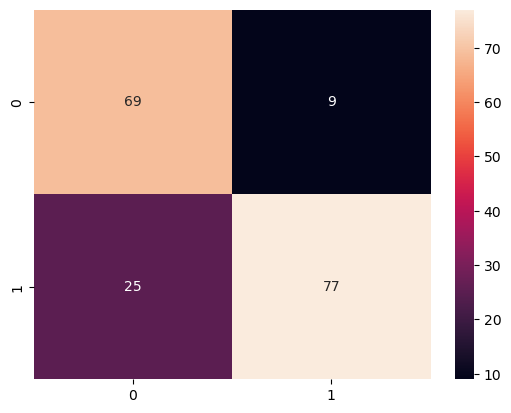

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(sns.heatmap(cm,annot=True))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples at each leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
    'bootstrap': [True, False]  # Whether to use bootstrap samples
}
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [14]:
best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_

print("Best parameters found: ", best_params)

y_pred_rf = best_rf_classifier.predict(X_test)

print("Random Forest (Tuned) Accuracy:")
print(accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Best parameters found:  {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest (Tuned) Accuracy:
0.8222222222222222
[[64 14]
 [18 84]]


In [15]:
lemmatizer = WordNetLemmatizer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

def preprocess_reviews(review):
    # Preprocess the review: cleaning and lemmatization
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in set(all_stopwords)]
    return ' '.join(review)

def predict_sentiment(reviews, model, vectorizer):
    sentiments = []

    for review in reviews:
        # Preprocess the review
        review = preprocess_reviews(review)

        # Transform the review using the trained TF-IDF vectorizer
        review_vector = vectorizer.transform([review]).toarray()

        # Predict sentiment using the trained Random Forest model
        prediction = model.predict(review_vector)

        # Append the sentiment result (Positive/Negative) to the list
        sentiments.append('Positive' if prediction == 1 else 'Negative')

    return sentiments

new_reviews = [
    "The food was absolutely wonderful, I will definitely come back!",
    "Worst dining experience, the food was cold and tasteless.",
    "A great meal with excellent service. Highly recommend!",
    "Not worth the price. The portion size was too small."
]

sentiments = predict_sentiment(new_reviews, best_rf_classifier, tfidf)

for review, sentiment in zip(new_reviews, sentiments):
    print(f"Review: '{review}'\nPredicted Sentiment: {sentiment}\n")

Review: 'The food was absolutely wonderful, I will definitely come back!'
Predicted Sentiment: Positive

Review: 'Worst dining experience, the food was cold and tasteless.'
Predicted Sentiment: Negative

Review: 'A great meal with excellent service. Highly recommend!'
Predicted Sentiment: Positive

Review: 'Not worth the price. The portion size was too small.'
Predicted Sentiment: Negative



In [16]:
import pickle
with open('sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(best_rf_classifier, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf, vectorizer_file)

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!
